# Imports

In [1]:
!pip install scikit-posthocs

In [2]:
# General
import os
import time
import random

# Linear Algebra
import numpy as np

# Multi thread & processing
import multiprocessing

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning general and Data Modelling
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize

# Image processing
import cv2
from sklearn.decomposition import PCA

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold, check_cv, train_test_split
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, rankdata
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.multiclass import unique_labels

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Exception
from sklearn.exceptions import NotFittedError

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Dataset

## Process

In [20]:
def get_list_of_files(directory):
  allFiles = []
  for root, dirs, files in os.walk(directory):
    for file in files:
        fullPath = os.path.join(root, file)
        allFiles.append(fullPath)
  return allFiles

def process_image(args):
    image_path, preprocessing_steps = args
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None

    if 'resize' in preprocessing_steps:
        img = resize_image(img)

    if 'histogram_equalization' in preprocessing_steps:
        img = histogram_equalization(img)

    if 'clahe' in preprocessing_steps:
        img = apply_clahe(img)

    if 'blur' in preprocessing_steps:
        img = blur_image(img)

    if 'background_removal' in preprocessing_steps:
        try:
            img = remove_background_binary(img)
        except Exception as e:
            print(f"Error in background removal for {image_path}: {e}")
            return None

    label = os.path.basename(os.path.dirname(image_path))
    return img, label, image_path

def prepare_data(dataset, num_workers=2, preprocessing_steps=None):
    if preprocessing_steps is None:
        preprocessing_steps = []

    args = [(image_path, preprocessing_steps) for image_path in dataset]

    with multiprocessing.Pool(num_workers) as pool:
        results = pool.map(process_image, args)

    results = [res for res in results if res is not None]

    data = [res[0] for res in results]
    labels = [res[1] for res in results]
    paths = [res[2] for res in results]

    return np.array(data), np.array(labels), paths


## Augmentation ( Don't run without examining )

In [ ]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def flip_image(image):
    return cv2.flip(image, 1)

def zoom_image(image, zoom_factor=1.2):
    h, w = image.shape[:2]
    center_x, center_y = w // 2, h // 2

    crop_x = int(w / zoom_factor)
    crop_y = int(h / zoom_factor)
    x1 = max(center_x - crop_x // 2, 0)
    y1 = max(center_y - crop_y // 2, 0)
    x2 = min(center_x + crop_x // 2, w)
    y2 = min(center_y + crop_y // 2, h)

    cropped = image[y1:y2, x1:x2]

    zoomed = cv2.resize(cropped, (w, h))
    return zoomed

def adjust_brightness_contrast(image, brightness=0, contrast=0):
    return cv2.convertScaleAbs(image, alpha=1 + contrast / 100, beta=brightness)

def shift_image(image, shift_x, shift_y):
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

def augment_image(image, techniques):
    augmented_images = []
    for technique in techniques:
        if technique == "rotate":
            angle = random.uniform(-30, 30)
            augmented_images.append(rotate_image(image, angle))
        elif technique == "flip":
            augmented_images.append(flip_image(image))
        elif technique == "zoom":
            zoom_factor = random.uniform(1.0, 1.2)
            augmented_images.append(zoom_image(image, zoom_factor))
        elif technique == "brightness_contrast":
            brightness = random.randint(-50, 50)
            contrast = random.randint(-30, 30)
            augmented_images.append(adjust_brightness_contrast(image, brightness, contrast))
        elif technique == "shift":
            shift_x, shift_y = random.randint(-10, 10), random.randint(-10, 10)
            augmented_images.append(shift_image(image, shift_x, shift_y))
    return augmented_images

In [ ]:
def augment_and_save(input_path, output_path, class_targets):
    print("Starting augmentation process...")
    for class_name, target_count in class_targets.items():
        class_input_path = os.path.join(input_path, class_name)
        class_output_path = os.path.join(output_path, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        # Get all images in this class folder
        image_files = [os.path.join(class_input_path, f) for f in os.listdir(class_input_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"Warning: No valid images found in {class_input_path}")
            continue

        # Calculate the required number of augmented images
        current_count = len(os.listdir(class_output_path))
        required_count = target_count - current_count

        if required_count <= 0:
            print(f"✔️ {class_name}: Already meets the target of {target_count} files.")
            continue

        print(f"Augmenting {class_name}: Need {required_count} more images.")

        augmented_count = 0
        while augmented_count < required_count:
            for image_path in image_files:
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Error: Failed to read image {image_path}")
                    continue

                # Apply augmentations
                img_rotated = rotate_image(img, random.randint(-30, 30))
                img_flipped = flip_image(img_rotated)
                img_zoomed = zoom_image(img_flipped, zoom_factor=1.2)
                brightness = random.randint(-50, 50)
                contrast = random.randint(-30, 30)
                img_brightness = adjust_brightness_contrast(img_zoomed, brightness=brightness, contrast=contrast)
                shift_x, shift_y = random.randint(-20, 20), random.randint(-20, 20)
                img_shifted = shift_image(img_brightness, shift_x, shift_y)

                # Save augmented image
                output_filename = f"{class_name}_{augmented_count + current_count + 1}.jpg"
                output_filepath = os.path.join(class_output_path, output_filename)
                cv2.imwrite(output_filepath, img_shifted)

                augmented_count += 1

                # Break if we reach the required count
                if augmented_count >= required_count:
                    break

        print(f"✔️ {class_name}: Augmentation completed. Total: {target_count} files.")


In [ ]:
def check_augmented_data(output_path, class_targets):
    print("Checking augmented dataset...")
    for class_name, target_count in class_targets.items():
        class_path = os.path.join(output_path, class_name)
        if not os.path.exists(class_path):
            print(f"Error: Class folder '{class_name}' does not exist in {output_path}")
            continue

        num_files = len([file for file in os.listdir(class_path) if not file.startswith('.')])
        if num_files == target_count:
            print(f"✔️ {class_name}: {num_files} files (Target: {target_count})")
        else:
            print(f"⚠️ {class_name}: {num_files} files (Target: {target_count}) - Check this class")

In [ ]:
train_dataset_path = "/content/drive/MyDrive/Research Leaf/dataset/train"
output_dataset_path = "/content/drive/MyDrive/Research Leaf/dataset/augmented_train"

In [ ]:
# Target Counts per Class
class_targets = {
    "Bacterial Blight": 400,
    "Blast": 400,
    "Brownspot": 400,
    "Smut": 400,
}

In [ ]:
augment_and_save(train_dataset_path, output_dataset_path, class_targets)

Starting augmentation process...
✔️ Bacterial Blight: Already meets the target of 400 files.
✔️ Blast: Already meets the target of 400 files.
✔️ Brownspot: Already meets the target of 400 files.
✔️ Smut: Already meets the target of 400 files.


# Image Processing

## Remove Background

In [5]:
def remove_background_binary(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    saturation = hsv_image[:, :, 1]
    _, binary_mask = cv2.threshold(saturation, 70, 255, cv2.THRESH_BINARY)
    masked_image = cv2.bitwise_and(image, image, mask=binary_mask)
    return masked_image

## Resize

In [6]:
def resize_image(image, size=(150, 150)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

## Histogram Equalization

In [7]:
def histogram_equalization(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[:, :, 2] = cv2.equalizeHist(hsv_image[:, :, 2])
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

## CLAHE(Contrast Limited Adaptive Histogram Equalization)

In [8]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    hsv_image[:, :, 2] = clahe.apply(hsv_image[:, :, 2])
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

## Noise Reduction (PCA)

In [9]:
def apply_pca(features, test_features, n_components):
  pca = PCA(n_components=n_components)
  features = pca.fit_transform(features)
  test_features = pca.transform(test_features)
  return features, test_features

## Blurring

In [10]:
def blur_image(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Image Segmentation

## Find Optimal Cluster

In [11]:
def find_optimal_k(gaps, s_k, max_k):
    for k in range(1, max_k):
        if gaps[k - 1] >= gaps[k] - s_k[k]:
            return k
    return max_k

def gap_statistic_for_k(pixel_values, k, n_refs=10, random_state=42):
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    kmeans.fit(pixel_values)

    disp = np.sum(np.min(pairwise_distances(pixel_values, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

    ref_disps = np.zeros(n_refs)
    for i in range(n_refs):
        random_reference = np.random.uniform(
            low=pixel_values.min(axis=0),
            high=pixel_values.max(axis=0),
            size=pixel_values.shape
        )
        kmeans.fit(random_reference)
        ref_disps[i] = np.sum(np.min(pairwise_distances(random_reference, kmeans.cluster_centers_, metric='euclidean')**2, axis=1))

    log_ref_disp = np.log(ref_disps + 1e-10)
    gap = np.mean(log_ref_disp) - np.log(disp + 1e-10)
    s_k = np.sqrt(np.sum((log_ref_disp - np.mean(log_ref_disp))**2) / n_refs)
    return gap, s_k

def calculate_gap_statistic(image, max_k=10, n_refs=10, random_state=42):
    pixel_values = np.ascontiguousarray(image.reshape((-1, 3)))
    gaps = np.zeros(max_k)
    s_k = np.zeros(max_k)

    for k in range(1, max_k + 1):
        gap, sk = gap_statistic_for_k(pixel_values, k, n_refs=n_refs, random_state=random_state)
        gaps[k - 1] = gap
        s_k[k - 1] = sk

    return gaps, s_k

## Segment

In [12]:
def k_mean_segmentation(disease, attempts=10, K=2):
    disease = remove_background_binary(disease)
    leaf_image = disease.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(leaf_image, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()].reshape(disease.shape)
    return segmented_image, labels, centers

def segment_image(image, K=2):
    return k_mean_segmentation(image, K=K)

def process_image(args):
    image, max_k = args
    # gaps, s_k = calculate_gap_statistic(image, max_k=max_k)
    # optimal_k = find_optimal_k(gaps, s_k, max_k)
    return k_mean_segmentation(image, K=8)

def parallel_segmentation(images, max_k=10, num_workers=2):
    with multiprocessing.get_context("fork").Pool(processes=num_workers) as pool:
        args = [(image, max_k) for image in images]
        results = pool.map(process_image, args)
    return results

In [13]:
def mask_filter(image, segmented_image, cluster, labels):
  mask = (labels.flatten() == cluster)
  filtered_image = np.zeros_like(segmented_image)
  filtered_image[mask.reshape(image.shape[:2])] = segmented_image[mask.reshape(image.shape[:2])]
  return filtered_image

# Feature Extraction

In [14]:
def extract_hsv_features(images, labels=None, centers=None, use_segmentation=True):
    """
    Extract mean HSV features from images (with or without segmentation).

    Parameters:
    - images: List of images (either segmented or original images).
    - labels: List of label arrays corresponding to each image (needed if use_segmentation=True).
    - centers: List of cluster center arrays corresponding to each image (needed if use_segmentation=True).
    - use_segmentation: Boolean flag to determine whether to use K-means segmentation or not.

    Returns:
    - features: Flattened HSV features for all images.
    """
    features = []

    for i, image in enumerate(images):
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        if use_segmentation:
            # Check that segmentation data is available
            if labels is None or centers is None:
                raise ValueError("When use_segmentation is True, labels and centers must be provided.")

            label_array = labels[i]
            center_array = centers[i]

            image_features = []
            num_clusters = len(center_array)

            for cluster_id in range(num_clusters):
                cluster_mask = (label_array.reshape(image.shape[:2]) == cluster_id)

                cluster_pixels = hsv_image[cluster_mask]

                if cluster_pixels.size > 0:
                    mean_hsv = cluster_pixels.mean(axis=0)
                else:
                    mean_hsv = [0, 0, 0]

                image_features.extend(mean_hsv)

        else:
            # Extract mean HSV of the entire image
            mean_hsv = hsv_image.mean(axis=(0, 1))
            image_features = mean_hsv

        features.append(image_features)

    return np.array(features)

In [15]:
def extract_histogram_features(images, labels_list=None, centers_list=None, hist_bins=16, use_segmentation=True):
    """
    Extract HSV histogram features for a list of images (with or without segmentation).

    Args:
    - images (list of np.array): List of images (either segmented or original).
    - labels_list (list of np.array, optional): List of label arrays corresponding to segmented images (needed if use_segmentation=True).
    - centers_list (list of np.array, optional): List of cluster centers (needed if use_segmentation=True).
    - hist_bins (int): Number of bins for the histogram (default is 16).
    - use_segmentation (bool): Flag to determine whether to use segmentation or not (default is True).

    Returns:
    - all_features (list of np.array): List of flattened histogram feature vectors for all images.
    """
    all_features = []

    for i, image in enumerate(images):
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        if use_segmentation:
            if labels_list is None or centers_list is None:
                raise ValueError("When use_segmentation is True, labels_list and centers_list must be provided.")

            labels = labels_list[i]
            centers = centers_list[i]

            for cluster_id in range(len(centers)):
                cluster_mask = (labels.reshape(image.shape[:2]) == cluster_id).astype(np.uint8)

                h_hist = cv2.calcHist([hsv_image], [0], cluster_mask, [hist_bins], [0, 180])
                s_hist = cv2.calcHist([hsv_image], [1], cluster_mask, [hist_bins], [0, 256])
                v_hist = cv2.calcHist([hsv_image], [2], cluster_mask, [hist_bins], [0, 256])

                h_hist = cv2.normalize(h_hist, h_hist).flatten()
                s_hist = cv2.normalize(s_hist, s_hist).flatten()
                v_hist = cv2.normalize(v_hist, v_hist).flatten()

                features.extend(h_hist)
                features.extend(s_hist)
                features.extend(v_hist)

        else:
            h_hist = cv2.calcHist([hsv_image], [0], None, [hist_bins], [0, 180])
            s_hist = cv2.calcHist([hsv_image], [1], None, [hist_bins], [0, 256])
            v_hist = cv2.calcHist([hsv_image], [2], None, [hist_bins], [0, 256])

            h_hist = cv2.normalize(h_hist, h_hist).flatten()
            s_hist = cv2.normalize(s_hist, s_hist).flatten()
            v_hist = cv2.normalize(v_hist, v_hist).flatten()

            features.extend(h_hist)
            features.extend(s_hist)
            features.extend(v_hist)

        all_features.append(np.array(features))

    return all_features

# Normalization

In [16]:
def normalize_features(features, method="standard"):
    """
    Normalize or standardize features.

    Parameters:
    - features: Feature matrix (NumPy array)
    - method: Normalization method, "standard" (default) or "minmax".

    Returns:
    - Normalized feature matrix.
    """
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")

    return scaler.fit_transform(features)

---

# Execution

---

In [17]:
train_ds = get_list_of_files("/content/drive/MyDrive/Research Leaf/dataset/train")
test_ds = get_list_of_files("/content/drive/MyDrive/Research Leaf/dataset/test")

In [18]:
print(f"{len(train_ds)}, {len(test_ds)}")

907, 224


In [21]:
preprocessing_steps = ['resize', 'clahe', 'blur']

# X_train, y_train, train_paths = prepare_data(train_ds, num_workers=2, use_background_removal=False)
# X_test, y_test, test_paths = prepare_data(test_ds, num_workers=2, use_background_removal=False)

X_train, y_train, train_paths = prepare_data(train_ds, 2, preprocessing_steps)
X_test, y_test, test_paths = prepare_data(test_ds, 2, preprocessing_steps)

## Without Segmentation

In [22]:
# X_train_hsv = extract_hsv_features(X_train, use_segmentation=False)
# X_test_hsv = extract_hsv_features(X_test, use_segmentation=False)

X_train_hsv = extract_histogram_features(X_train, use_segmentation=False)
X_test_hsv = extract_histogram_features(X_test, use_segmentation=False)

In [23]:
if X_train.ndim > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

## K Mean Segmentation





In [ ]:
train_segmented_images = parallel_segmentation(X_train, max_k=8, num_workers=2)


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object


In [ ]:
test_segmented_images = parallel_segmentation(X_test, max_k=8, num_workers=2)

In [ ]:
train_segmented = [segmented_image for segmented_image, _, _ in train_segmented_images]
train_labels = [label for _, label, _ in train_segmented_images]
train_centers = [center for _, _, center in train_segmented_images]

In [ ]:
test_segmented = [segmented_image for segmented_image, _, _ in test_segmented_images]
test_labels = [label for _, label, _ in test_segmented_images]
test_centers = [center for _, _, center in test_segmented_images]

### Post Clustering

In [ ]:
bacterial_blight = cv2.imread("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Train/Bacterial Blight/0.jpg")
bacterial_blight = remove_background_binary(bacterial_blight)
segmented_bacterial_blight, bacterial_blight_labels, bacterial_blight_centers = segment_image(bacterial_blight, K=8)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(4, 3, 1)
plt.title("Original Image")
plt.imshow(bacterial_blight)
plt.axis("off")

for cluster in range(len(bacterial_blight_centers)):
  filtered_test_image = mask_filter(bacterial_blight, segmented_bacterial_blight, cluster, bacterial_blight_labels)

  plt.subplot(4, 3, cluster + 2)
  plt.title(f'Segmented Cluster {cluster}')
  plt.imshow(filtered_test_image)
  plt.axis("off")

plt.show()

In [ ]:
def get_disease_reference(disease):
  disease_reference = np.load(disease)
  disease_mean_hsv = cv.mean(disease_reference)[:3]
  disease_mean_hsv = normalize_hsv(disease_mean_hsv)

  return disease_mean_hsv

In [ ]:
bacterial_blight_reference = get_disease_reference("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Reference/bacterial_blight_reference.npy")
blast_reference = get_disease_reference("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Reference/blast_reference.npy")
brownspot_reference = get_disease_reference("/content/drive/MyDrive/Research Leaf/ASHIIQ/compute_ashiq/Reference/brownspot_reference.npy")

reference_hsv_dict = {
    "Bacterial Blight": bacterial_blight_reference,
    "Blast": blast_reference,
    "Brownspot": brownspot_reference,
}

In [ ]:
def choose_right_cluster(image, segmented_image, K, )

### HSV & Histogram

In [ ]:
X_train = extract_histogram_features(train_segmented, train_labels, train_centers)
X_test = extract_histogram_features(test_segmented, test_labels, test_centers)

# X_train = extract_hsv_features(train_segmented, train_labels, train_centers)
# X_test = extract_hsv_features(test_segmented, test_labels, test_centers)

## Normalize

In [24]:
X_train_normalized = normalize_features(X_train_hsv, method="minmax")
X_test_normalized = normalize_features(X_test_hsv, method="minmax")

In [25]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## PCA Reduction

In [ ]:
X_train_reducted, X_test_reducted = apply_pca(X_train_normalized, X_test_normalized, n_components=1)

## Select KBest

In [ ]:
selector = SelectKBest(score_func=f_classif, k=500)
X_train_selected = selector.fit_transform(X_train_normalized, y_train)
X_test_selected = selector.transform(X_test_normalized)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=500 is greater than n_features=48. All the features will be returned.
  warnings.warn(


---
## Evaluation

In [26]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', C=10, probability=True),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=3),
}

In [27]:
for name, model in models.items():
    model.fit(X_train_normalized, y_train)

### Confusion Matrix

#### Heatmap

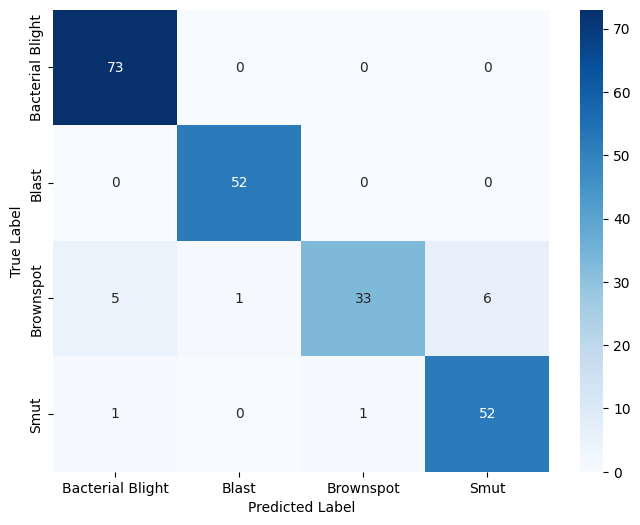

In [28]:
model_performance = {}
for name, model in models.items():
    y_pred = model.predict(X_test_normalized)
    acc = accuracy_score(y_test, y_pred)
    model_performance[name] = acc

best_model_name = max(model_performance, key=model_performance.get)
best_model = models[best_model_name]
best_accuracy = model_performance[best_model_name]

def plot_best_cm_heatmap(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=np.unique(y_test), yticklabels=np.unique(y_test)
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_best_cm_heatmap(best_model, X_test_normalized, y_test, best_model_name)

In [29]:
def evaluate_cm_heatmap(models, X_test, y_test, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easier indexing

    for idx, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            ax=axes[idx]
        )
        axes[idx].set_title(f"Confusion Matrix: {name}")
        axes[idx].set_xlabel("Predicted Label")
        axes[idx].set_ylabel("True Label")

    # Hide any unused subplots
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

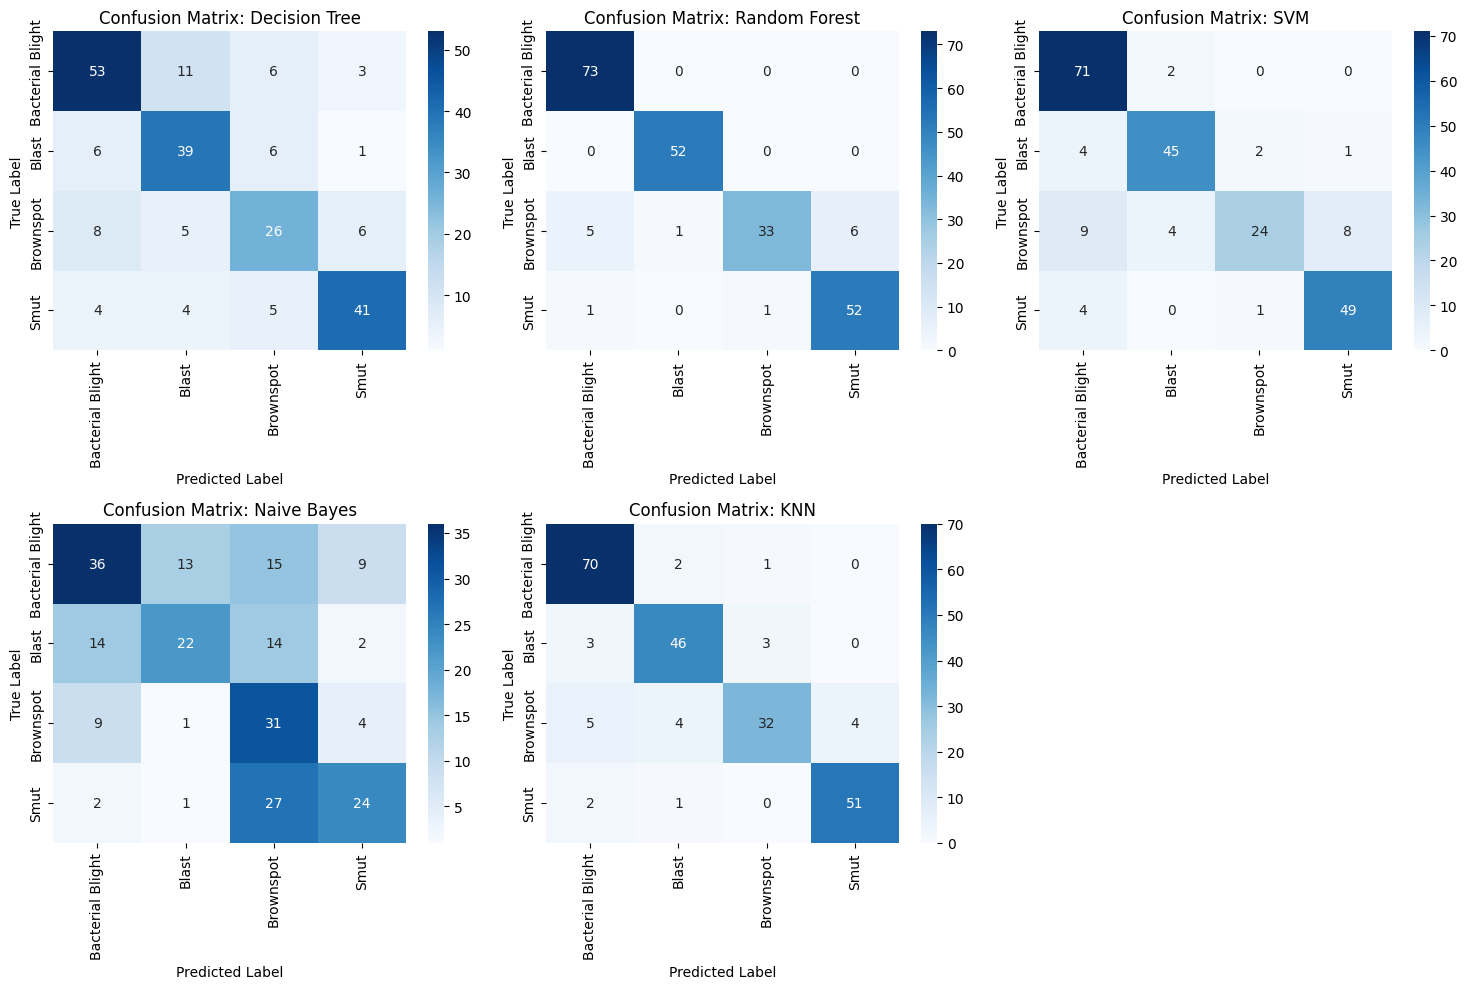

In [30]:
evaluate_cm_heatmap(models, X_test_normalized, y_test)

#### Metric Visualization

In [31]:
def calculate_metrics(models, X_test, y_test):
    metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

    for name, model in models.items():
        y_pred = model.predict(X_test)
        metrics["Model"].append(name)
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred, average="weighted"))
        metrics["Recall"].append(recall_score(y_test, y_pred, average="weighted"))
        metrics["F1-Score"].append(f1_score(y_test, y_pred, average="weighted"))

    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index("Model", inplace=True)

    ax = metrics_df.plot(kind="bar", figsize=(18, 12), width=0.7, colormap="viridis")
    plt.ylabel("Score", fontsize=24)
    plt.xticks(rotation=45, fontsize=18, ha="right")
    plt.yticks(fontsize=24)
    plt.grid(axis="y")

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=18
        )

    plt.xlabel("Model", fontsize=24)
    plt.tight_layout(pad=5)
    plt.show()

    return metrics_df


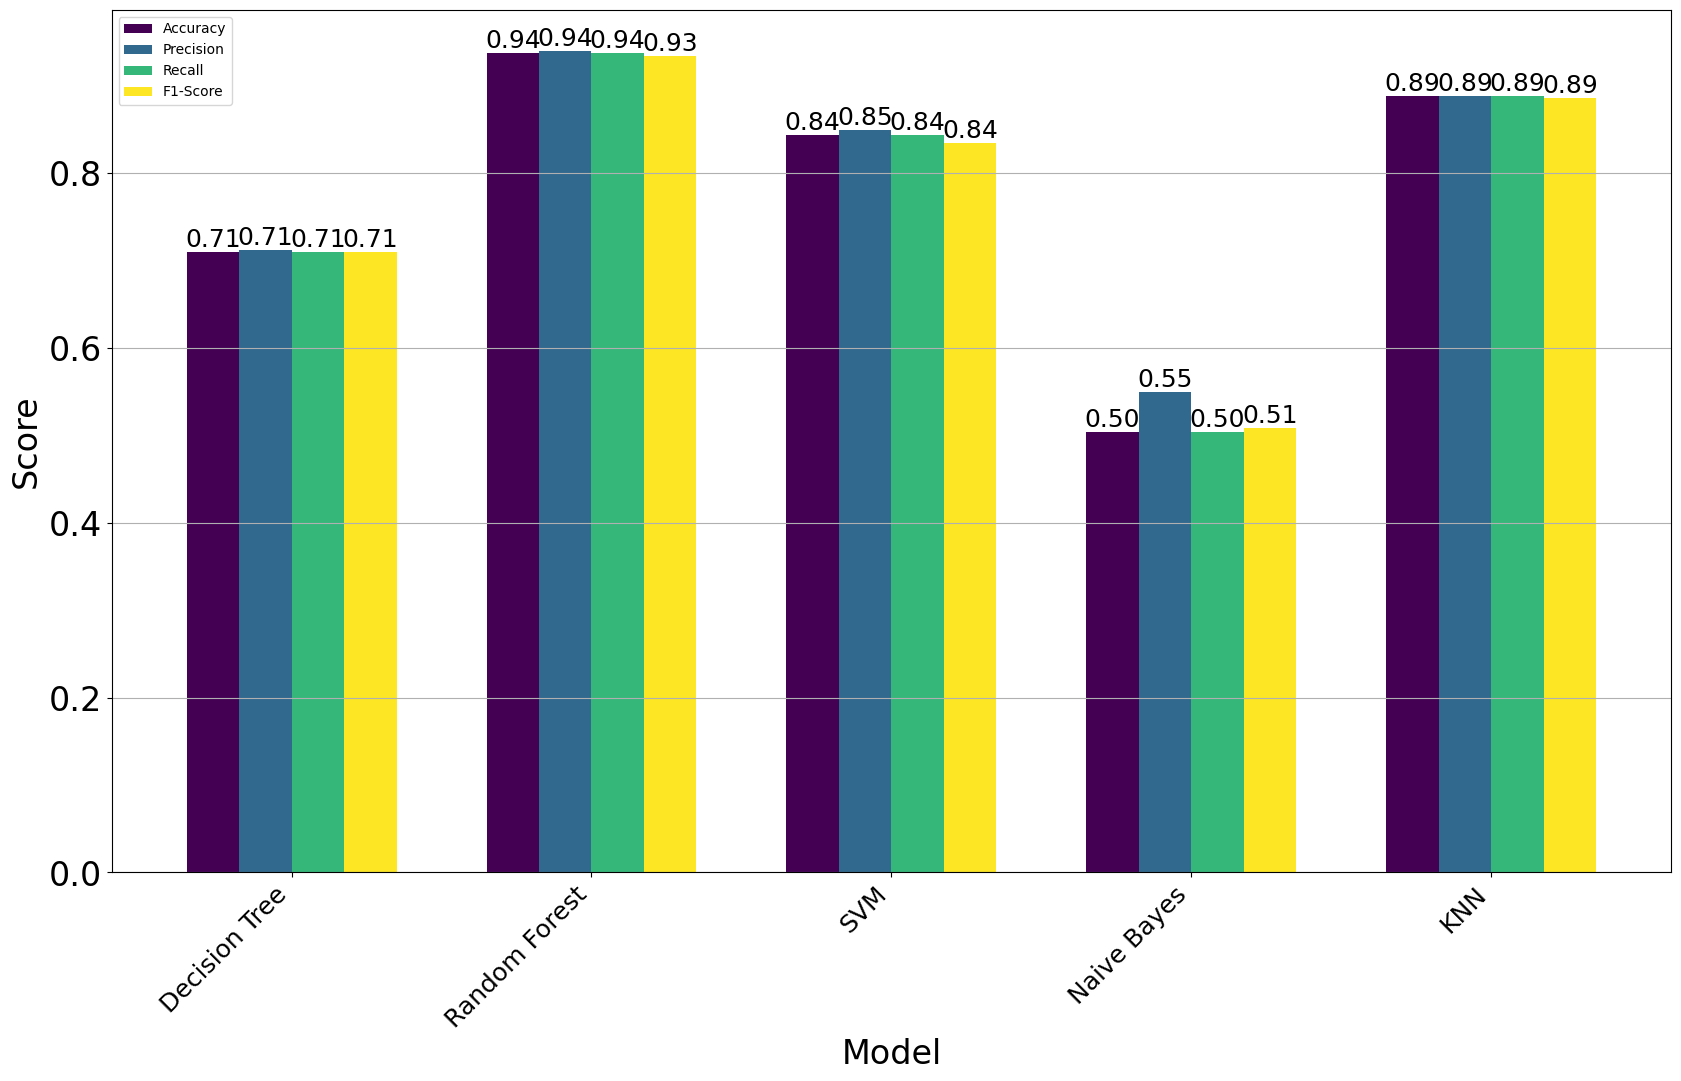

In [32]:
metrics_df = calculate_metrics(models, X_test_normalized, y_test)

#### Time Metrics

In [33]:
def calculate_time_metrics(models, X_train, y_train, X_test):
    times = {"Model": [], "Training Time (s)": [], "Prediction Time (s)": []}

    for name, model in models.items():
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()

        start_predict = time.time()
        model.predict(X_test)
        end_predict = time.time()

        times["Model"].append(name)
        times["Training Time (s)"].append(end_train - start_train)
        times["Prediction Time (s)"].append(end_predict - start_predict)

    time_metrics = pd.DataFrame(times)
    time_metrics.set_index("Model", inplace=True)
    ax = time_metrics.plot(kind="bar", figsize=(18, 12), width=0.7, colormap="coolwarm")

    plt.ylabel("Time (seconds)", fontsize=30)
    plt.xticks(rotation=45, fontsize=30, ha="right")
    plt.yticks(fontsize=30)
    plt.grid(axis="y")

    ax.set_xlabel("Model", fontsize=36, labelpad=20)

    plt.legend(fontsize=24, title="Models", title_fontsize=28, loc="upper right")

    plt.tight_layout(pad=5)
    plt.show()

    return time_metrics


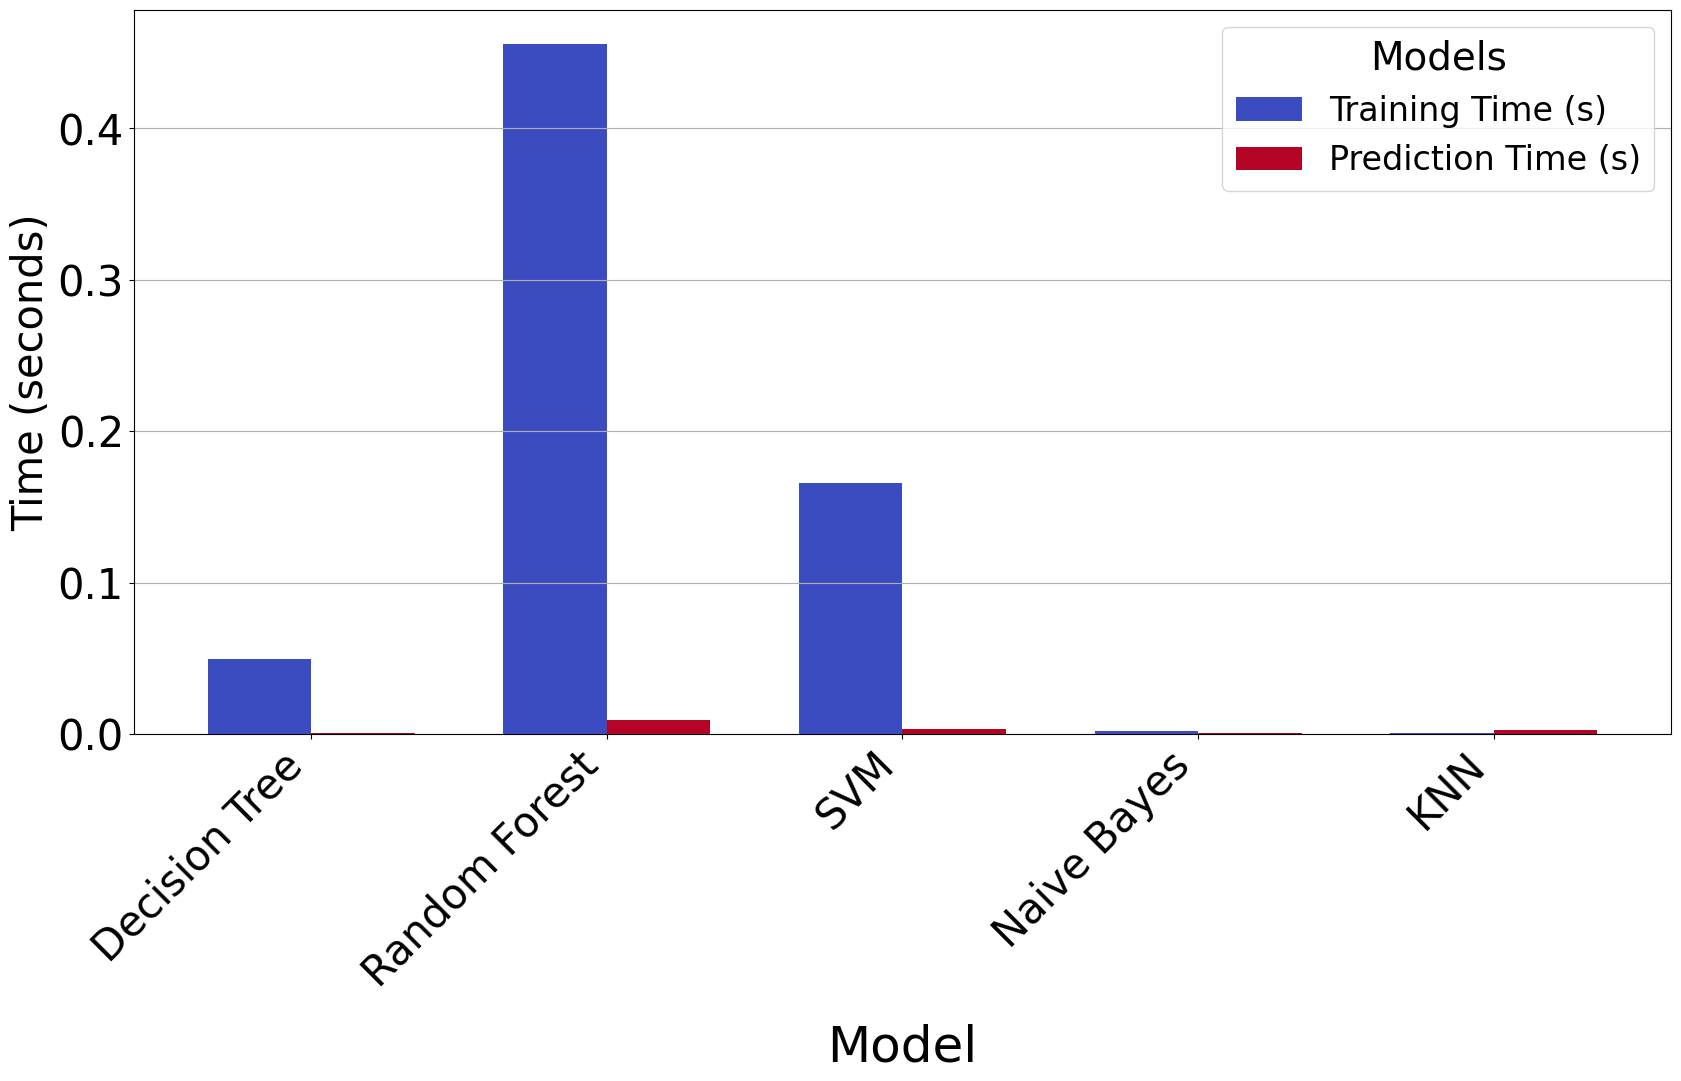

In [34]:
time_metrics_df = calculate_time_metrics(models, X_train_normalized, y_train, X_test_normalized)

### ROC_AUC Score

In [35]:
def plot_roc_comparison(models, X_test, y_test, class_labels):
    y_test_binarized = label_binarize(y_test, classes=class_labels)
    n_classes = len(class_labels)

    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        else:
            raise ValueError(f"Model {model_name} does not support probability predictions.")

        fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
        model_auc = auc(fpr, tpr)

        plt.plot(
            fpr,
            tpr,
            label=f"{model_name} (AUC = {model_auc:.2f})"
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Guess")

    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


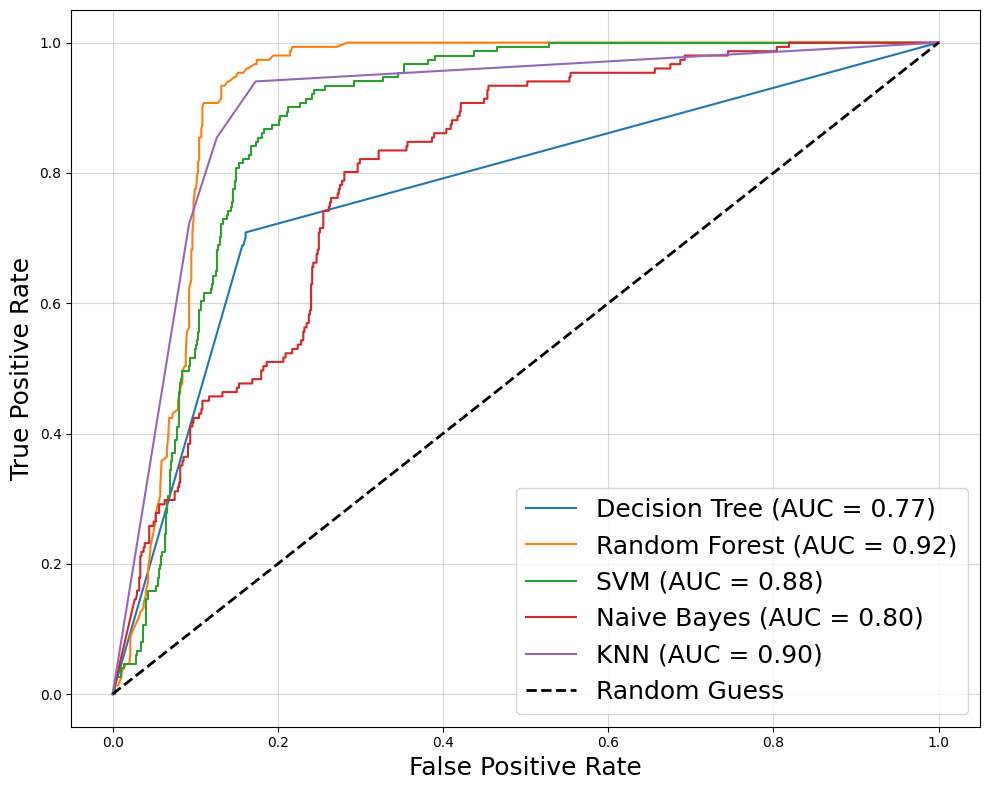

In [36]:
class_labels = ["Bacterial blight", "Blast", "Brownspot", "Smut"]
plot_roc_comparison(models, X_test_normalized, y_test, class_labels)

### Learning Curves

In [37]:
def evaluate_learning_curves(models, X, y, cv=10, scoring="accuracy"):

    plt.figure(figsize=(15, 8))

    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, model in models.items():
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=stratified_cv, scoring=scoring, n_jobs=-1, error_score='raise'
        )
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.plot(train_sizes, test_mean, label=f"{name} (CV Score)", marker="o")
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.title("Learning Curves for Multiple Models")
    plt.xlabel("Training Size")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

In [38]:
def train_and_plot_learning_curves(models, X_train, y_train, scoring='accuracy'):

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"Training {name}...")

        # Generate learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=X_train,
            y=y_train,
            cv=cv_strategy,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring=scoring
        )

        # Calculate mean and standard deviation
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curve
        plt.figure(figsize=(8, 6))
        plt.title(f"Learning Curve: {name}")
        plt.xlabel("Training Set Size")
        plt.ylabel(scoring.capitalize())
        plt.grid()

        # Plot training and test scores

        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

        plt.legend(loc="best")
        plt.show()

Training Decision Tree...


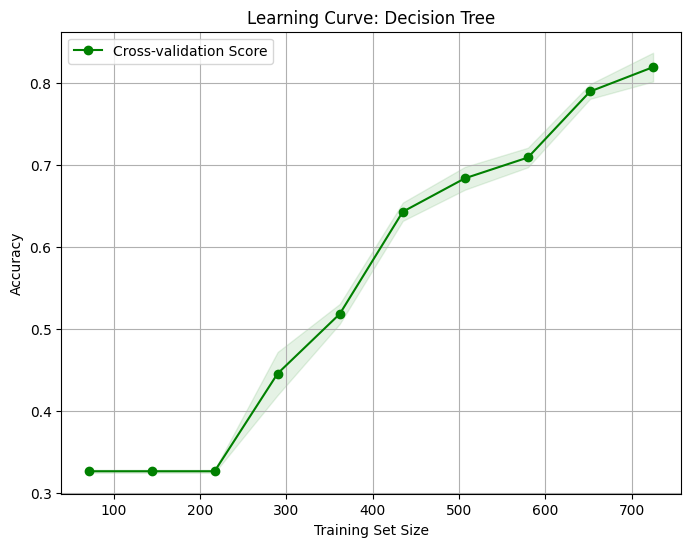

Training Random Forest...


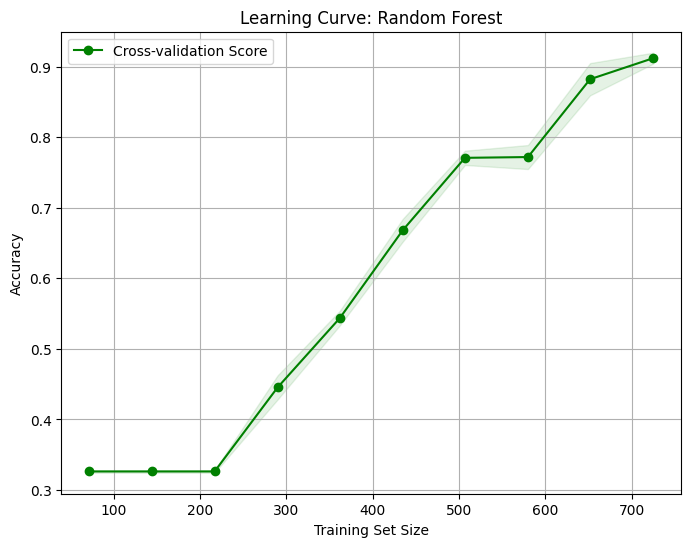

Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
      

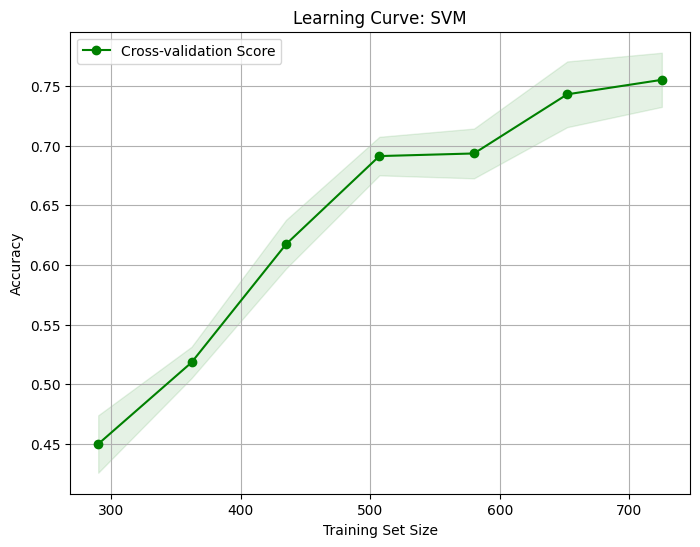

Training Naive Bayes...


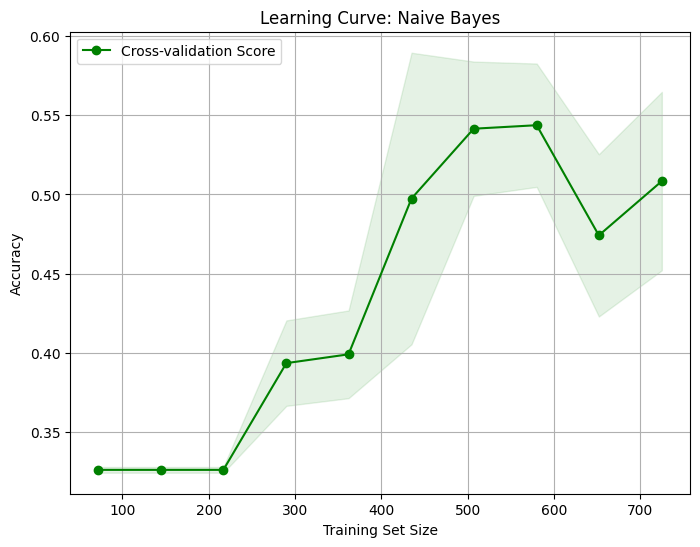

Training KNN...


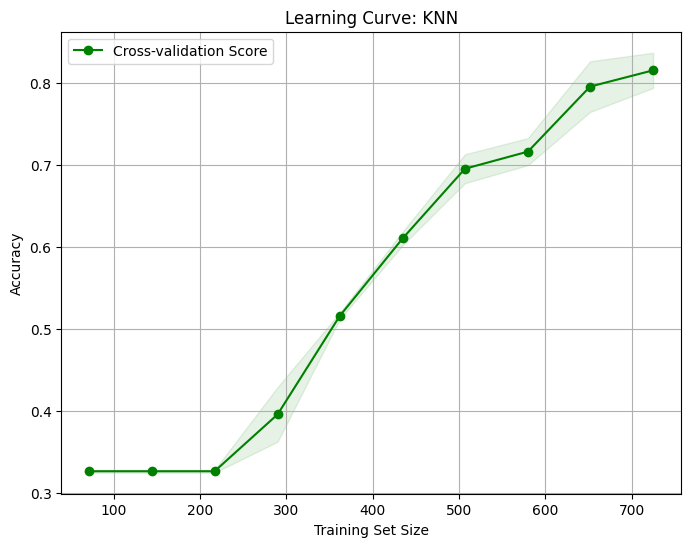

In [39]:
train_and_plot_learning_curves(models, X_train_normalized, y_train_encoded)

In [40]:
from collections import Counter
print(Counter(y_train))

Counter({'Bacterial Blight': 296, 'Smut': 220, 'Blast': 210, 'Brownspot': 181})


In [41]:
for train_idx, test_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train):
    print("Train class distribution:", Counter(y_train[train_idx]))
    print("Test class distribution:", Counter(y_train[test_idx]))

Train class distribution: Counter({'Bacterial Blight': 236, 'Smut': 176, 'Blast': 168, 'Brownspot': 145})
Test class distribution: Counter({'Bacterial Blight': 60, 'Smut': 44, 'Blast': 42, 'Brownspot': 36})
Train class distribution: Counter({'Bacterial Blight': 237, 'Smut': 176, 'Blast': 168, 'Brownspot': 144})
Test class distribution: Counter({'Bacterial Blight': 59, 'Smut': 44, 'Blast': 42, 'Brownspot': 37})
Train class distribution: Counter({'Bacterial Blight': 237, 'Smut': 176, 'Blast': 168, 'Brownspot': 145})
Test class distribution: Counter({'Bacterial Blight': 59, 'Smut': 44, 'Blast': 42, 'Brownspot': 36})
Train class distribution: Counter({'Bacterial Blight': 237, 'Smut': 176, 'Blast': 168, 'Brownspot': 145})
Test class distribution: Counter({'Bacterial Blight': 59, 'Smut': 44, 'Blast': 42, 'Brownspot': 36})
Train class distribution: Counter({'Bacterial Blight': 237, 'Smut': 176, 'Blast': 168, 'Brownspot': 145})
Test class distribution: Counter({'Bacterial Blight': 59, 'Smut': 

### Friedman & PostHoc

In [42]:
def get_cv_results(models, X, y, cv=5, scoring="accuracy"):
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        results[name] = scores
        print(f"{name}: Mean CV Score = {scores.mean():.4f} ± {scores.std():.4f}")
    return results

In [43]:
def perform_friedman_test(results):
    scores = list(results.values())
    stat, p = friedmanchisquare(*scores)
    print(f"Friedman Test Statistic: {stat:.2f}, p-value: {p:.4f}")
    return stat, p

In [44]:
def perform_post_hoc_test(results):
    scores = np.array(list(results.values())).T

    nemenyi = sp.posthoc_nemenyi_friedman(scores)
    print("Post-Hoc Test (Nemenyi):\n", nemenyi)

    return nemenyi

In [45]:
cv_results = get_cv_results(models, X_train_normalized, y_train)

Decision Tree: Mean CV Score = 0.7927 ± 0.0288
Random Forest: Mean CV Score = 0.8754 ± 0.0388
SVM: Mean CV Score = 0.7013 ± 0.0465
Naive Bayes: Mean CV Score = 0.4752 ± 0.0502
KNN: Mean CV Score = 0.7806 ± 0.0233


In [46]:
perform_friedman_test(cv_results)

Friedman Test Statistic: 19.36, p-value: 0.0007


(19.36, 0.0006677296603150804)

In [47]:
p_values = perform_post_hoc_test(cv_results)

Post-Hoc Test (Nemenyi):
           0         1         2         3         4
0  1.000000  0.751424  0.373481  0.040876  0.975123
1  0.751424  1.000000  0.022659  0.000606  0.373481
2  0.373481  0.022659  1.000000  0.855475  0.751424
3  0.040876  0.000606  0.855475  1.000000  0.179597
4  0.975123  0.373481  0.751424  0.179597  1.000000


In [48]:
p_values_filled = np.nan_to_num(p_values, nan=1.0)

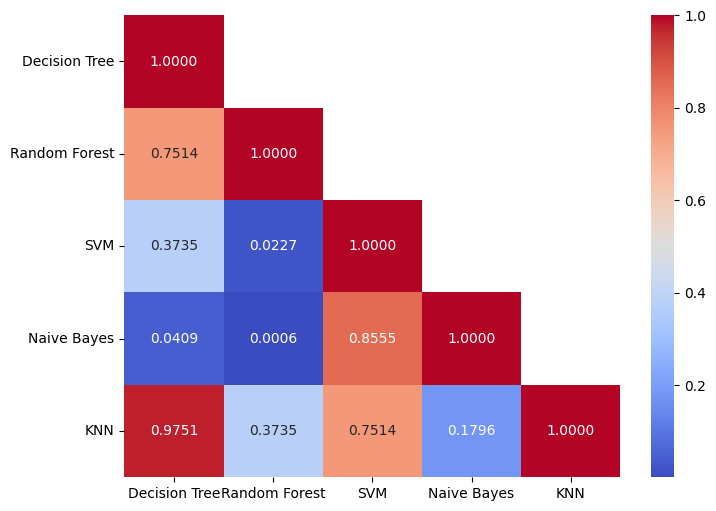

In [49]:
p_values_df = pd.DataFrame(p_values_filled, columns=models, index=models)

plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(p_values_filled, dtype=bool), k=1)
sns.heatmap(p_values_df, annot=True, fmt=".4f", cmap="coolwarm", cbar=True, mask=mask)
plt.show()